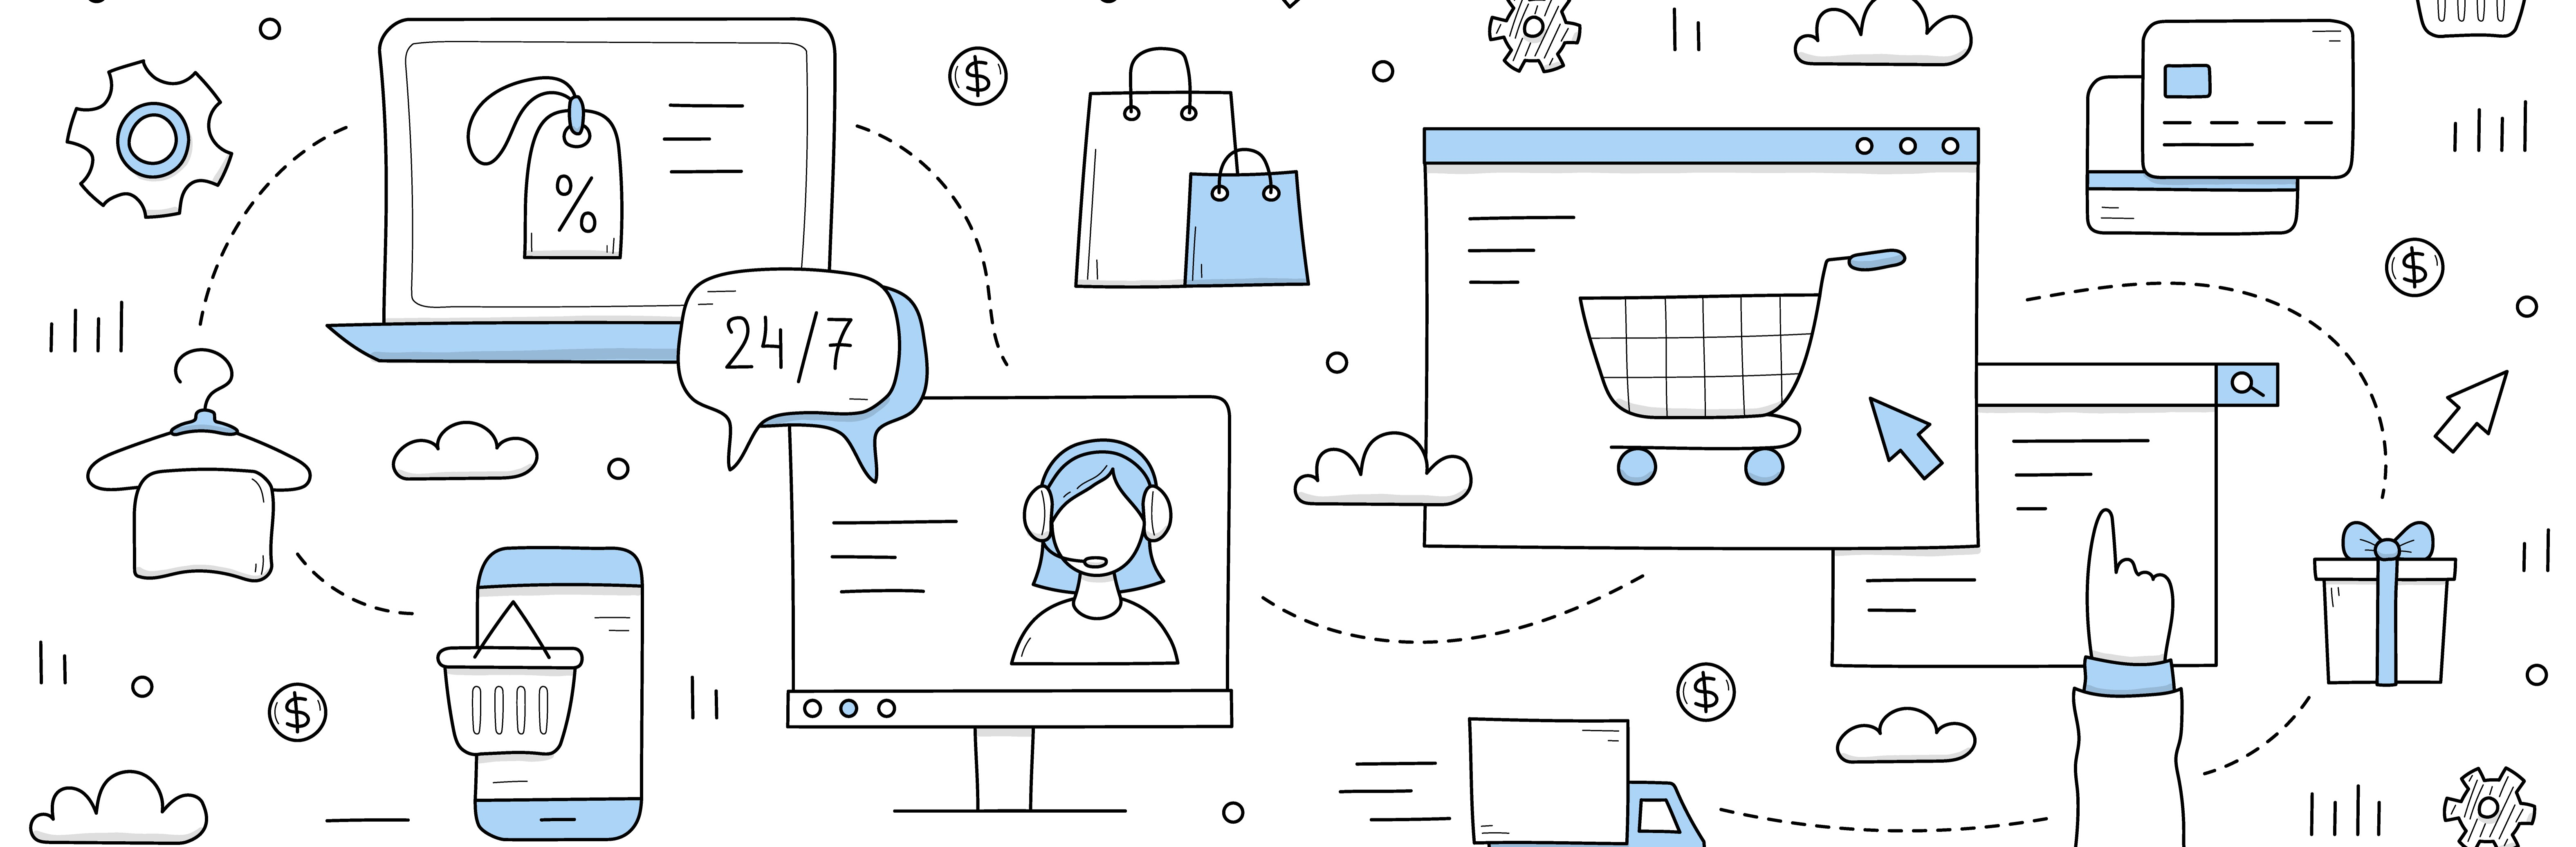

## 

# Data cleaning 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("data.csv", encoding='latin1')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot: >

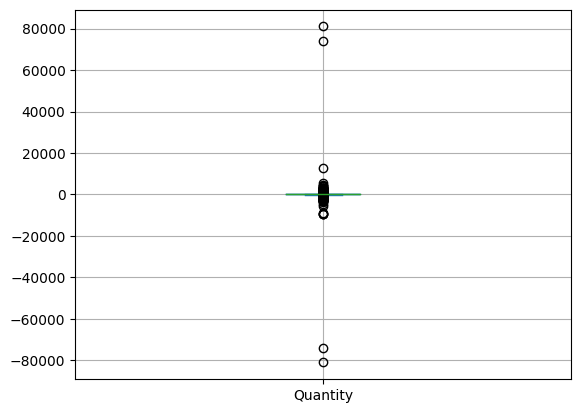

In [5]:
df["Quantity"].plot.box(grid='True')

### 

### removing outliers

In [6]:
def detect_outliers(data):
    outlier=[]
    threshold=3
    mean=np.mean(data)
    std=np.std(data)
    for i in data:
        z_score=(i-mean)/std
        if np.abs(z_score)>threshold:
            outlier.append(i)
    return outlier

In [7]:
a=detect_outliers(df["Quantity"])
df["Quantity"]= df["Quantity"].replace([a],np.nan)

### 

### Treating Null values 

In [8]:
df["Quantity"].fillna(np.mean(df["Quantity"]), inplace = True)

#For CustomerID it's seems like continue flow so i chose to pick upper values to treat null values 
df['CustomerID'] = df['CustomerID'].fillna(method='ffill')

In [9]:
df.dropna(inplace=True)

### 

In [10]:
#In Quantity some values are in negative but it's not make sense to be in negative
#so i choose to convert negative values as positive 

df["Quantity"] =df["Quantity"].abs()

<AxesSubplot: >

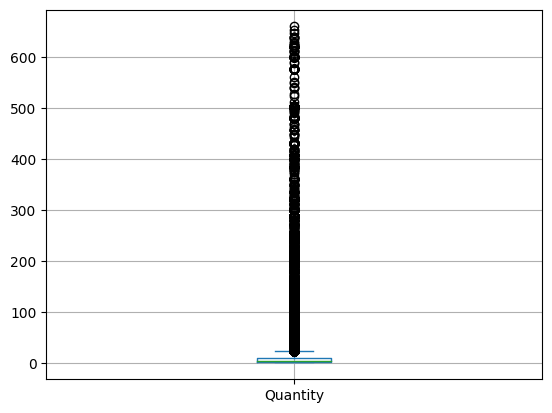

In [11]:
df["Quantity"].plot.box(grid='True')

### 

# NLP

### 

### NLP data cleaning 

In [12]:
# Removing everything except Words and numbers 

df['Description'] = df['Description'].str.replace("[^a-zA-Z0-9]", " ")

In [13]:
# It's seems some of the value are in float so i change the entire column as string

df['Description'] = df['Description'].astype(str)

In [14]:
# Removing All words under 2 letters

df['Description'] = df['Description'].apply(lambda row: ' '.join([word for word in row.split() if len(word)>2]))

In [15]:
# most of the data seems to be in uppercase ,just for a precautions i converter every think in lowercase 

df['Description'] = [review.lower() for review in df['Description']]

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart light holder,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 

### tokenization

In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def remove_stopwords(rev):
    # iNPUT : IT WILL TAKE ROW/REVIEW AS AN INPUT
    # take the paragraph, break into words, check if the word is a stop word, remove if stop word, combine the words into a para again
    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new

In [19]:
df['Description'] = [remove_stopwords(r) for r in df['Description']]

### 

### Lemmatization

In [20]:
# Begin Lemmatization 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()

# Finds the part of speech tag
# Convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
  # word tokenize -> pos tag (detailed) -> wordnet tag (shallow pos) -> lemmatizer -> root word
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


df['Description'] = df['Description'].apply(lambda x: lemmatize_sentence(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 

In [21]:
df['Description']

0            white hang heart light holder
1                      white metal lantern
2            cream cupid heart coat hanger
3         knit union flag hot water bottle
4            red woolly hottie white heart
                        ...               
541904                pack spaceboy napkin
541905              child apron dolly girl
541906        childrens cutlery dolly girl
541907     childrens cutlery circus parade
541908            bake set piece retrospot
Name: Description, Length: 540455, dtype: object

# 

### Visualization 

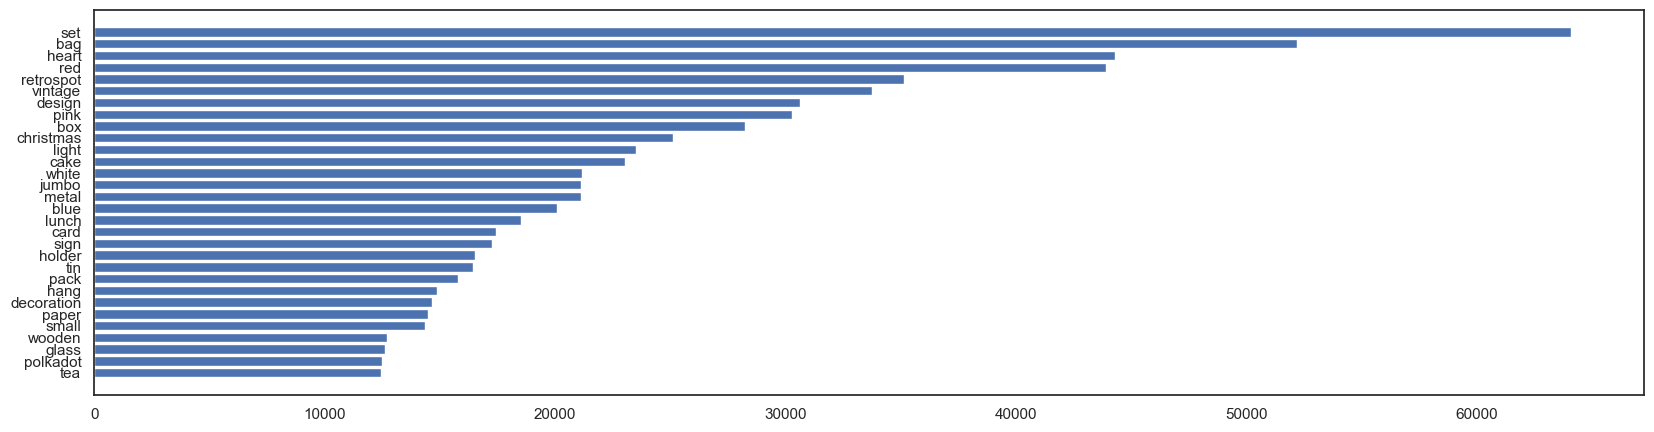

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white')
from nltk import FreqDist #function to find the frequent words in the data

#Extracts words into list and count frequency
all_words = ' '.join([text for text in df['Description']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

### 

### Bagging

In [23]:
# Importing module
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)

x = tfidf.fit_transform(df.Description)

feature_names = tfidf.get_feature_names()
x=pd.DataFrame(x.toarray(), columns = feature_names)

In [24]:
df=pd.DataFrame(df)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hang heart light holder,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid heart coat hanger,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,knit union flag hot water bottle,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [25]:
df = df.drop(["InvoiceNo","Description",'InvoiceDate'], axis='columns')

### 

### Encoding 

In [27]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['Country']= label_encoder.fit_transform(df['Country'])
df['StockCode']= label_encoder.fit_transform(df['StockCode'])

### 

### Scaling 

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(df) # standardise data

In [29]:
X_std=pd.DataFrame(X_std)

### 

### Merging Bagged  Datas & Normal datas

In [30]:
X_std= pd.concat([X_std,x], axis=1)

In [31]:
X_std.head()

,0,1,2,3,4,125g,15c,15cm,200,250g,...,wool,woolly,word,world,woven,wrap,wreath,write,yellow,zinc
0,2.002132,-0.147688,-0.021401,1.483222,0.280056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.235834,-0.147688,-0.012731,1.483222,0.280056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.494556,-0.070308,-0.019337,1.483222,0.280056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.433164,-0.147688,-0.012731,1.483222,0.280056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.432068,-0.147688,-0.012731,1.483222,0.280056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.614163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 

### **Determining K using Elbow plot**

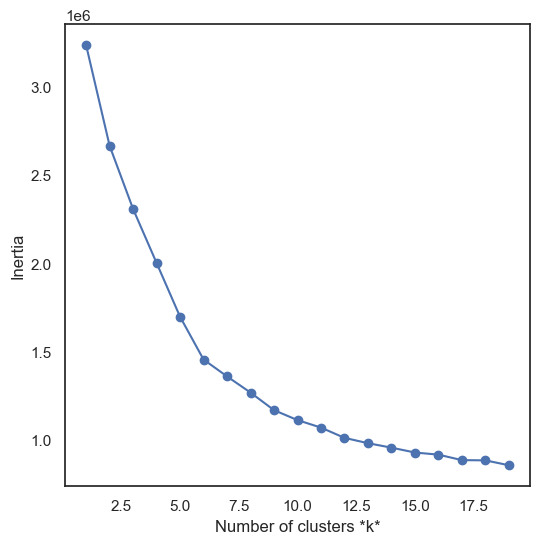

In [32]:
from sklearn.cluster import KMeans
inertias = []  # storer inertia for all values of k 
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    inertias.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, inertias, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Inertia'); 

# 

# Fitting a model 

In [33]:
#After observing Elbow plot I chose 6 as my K value 

from sklearn.cluster import KMeans
km = KMeans(n_clusters=6) # applying k = 6
km.fit(X_std)

KMeans(n_clusters=6)